# Skin Cancer Prediction 

Skin cancer is a type of cancer that originates in the skin. It occurs when there is an uncontrolled growth of abnormal skin cells. Skin cancer is one of the most common types of cancer worldwide, but it is also one of the most preventable and curable forms of cancer if detected and treated early.

In this dataset there are 7 types of cancer which are as follows:

1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma


To predict the type of cancer we had build a model based on CNN(Convolutional Neural Network) as CNNs are well-suited for image-based tasks and have achieved remarkable success in various computer vision applications, including medical imaging.

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob #use for file or directory pattern matching
import matplotlib.pyplot as plt #use to plot visualizations
import seaborn as sns # same as plt
from PIL import Image # PIL(Python Imaging Library ) use for Image Processing tasks like open , manipulate , saving ,etc.
from sklearn.model_selection import train_test_split # use to split dataset into training and testing dataset
from keras.utils.np_utils import to_categorical # use to convert integer labels into one-hot encoded vector
from keras.models import Sequential # use to create neural network models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D # use to add layers in model
from keras.optimizers import Adam # It is use to optimize the cost or loss function or to train deep neural network
from keras.callbacks import ReduceLROnPlateau # use to adjust the learning rate of an optimizer
from keras.preprocessing.image import ImageDataGenerator # use for data augmentation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Reading File

In [2]:
skin_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [3]:
skin_df.shape

(10015, 7)

There are 10,015 rows and 7 columns


Creating a dictionary consisting of image name and it's corresponding path

In [4]:
#here glob is use to search pattern
#splitext is use to split extension and basename
imageid_path_dict = { os.path.splitext(os.path.basename(x))[0] :x for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000' , '*' ,'*.jpg'))}


In [5]:
# lesion_type will be use for displaying type of cancer in human-friendly labels
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Processing Data

In this we have appended 3 columns name 'path' which specifies the path of image, 'cell_type' which specifies the lesion type and 'cell_type_idx' specifies the code of lesion type from 0 to 6

In [6]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [7]:
#Here is the sample of dataset 
skin_df.sample(4)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
8295,HAM_0004432,ISIC_0024529,nv,histo,25.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Melanocytic nevi,4
826,HAM_0004632,ISIC_0032159,bkl,confocal,70.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1943,HAM_0007016,ISIC_0027838,mel,histo,35.0,female,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Melanoma,5
3015,HAM_0002202,ISIC_0027315,nv,follow_up,50.0,male,trunk,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Melanocytic nevi,4


# Cleaning the Dataset

In [8]:
#checking if there is null or not 
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

So there are 57 null values in age so we will impute the age column using age mean value

In [9]:
skin_df['age'].fillna(skin_df['age'].mean() , inplace = True)

In [10]:
#checking for any duplicated data in dataset
skin_df.duplicated().sum()

0

# Visualization of Data

Doing univariate Visualization on dx_type, age, sex, localization, cell_type.

Here dx_type represents the type of test which are used to detect lesion type.

1. Histopathology (Histo): Histopathology is the study of changes in tissues caused by disease. It involves examining tissue samples under a microscope to identify and diagnose diseases, such as cancer.

2. Confocal: Confocal microscopy is an imaging technique used in histopathology to obtain high-resolution images of tissues. It uses a laser to illuminate specific sections of a tissue sample, while a pinhole aperture selectively detects the emitted light. This technique allows for the visualization of structures within the tissue at various depths, providing detailed information about cellular morphology and organization.

3. Follow-up: Follow-up refers to the subsequent monitoring or examination of a patient after an initial diagnosis or treatment. It involves regular visits or tests to assess the progress of the disease, evaluate the effectiveness of the treatment, and detect any potential recurrence or progression.

4. Consensus: Consensus refers to an agreement or convergence of opinions among pathologists or a multidisciplinary team involved in the interpretation of tissue samples. In complex cases, multiple pathologists may review the same sample independently and then come to a consensus regarding the diagnosis and other important factors. Consensus helps ensure accuracy and reliability in the interpretation of histopathological findings.


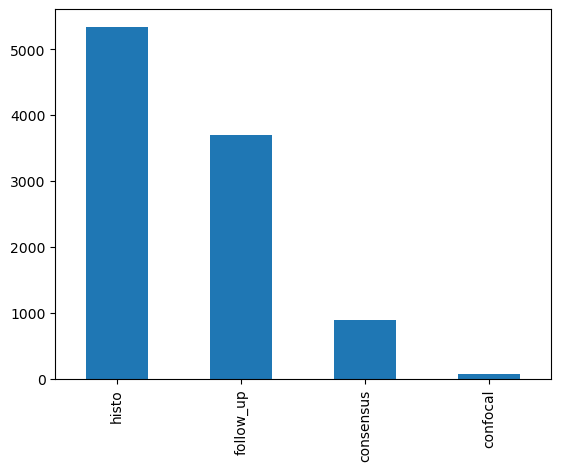

In [11]:
#plotting bar chart for 'dx_type' column
skin_df['dx_type'].value_counts().plot(kind='bar')
plt.show()

Looking at bar chart it seems histopathology method is widely use then after follow_up then consensus and the confocal is used least

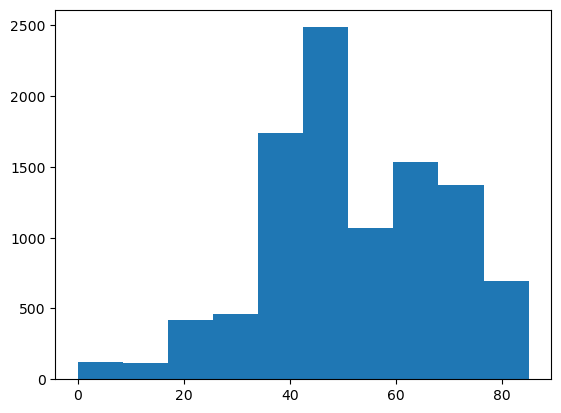

In [12]:
#plotting histograph for age distribution
plt.hist(skin_df['age'])
plt.show()

It seems age between 35 to 70 are more likely to have cancer

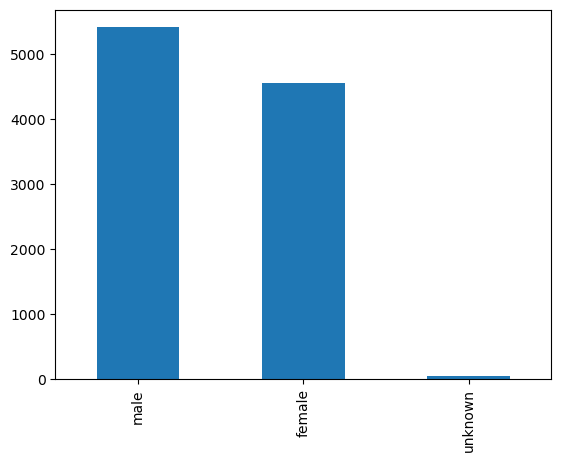

In [13]:
#plotting bar chart for sex column
skin_df['sex'].value_counts().plot(kind='bar')
plt.show()

There is slight diffrence between number of male and female. 

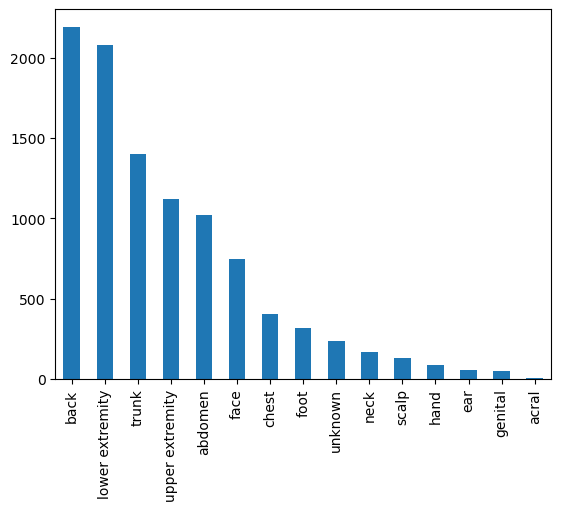

In [14]:
skin_df['localization'].value_counts().plot(kind='bar')
plt.show()

Back , lower extrimity , trunk , upper extremity , abdomen and face have higher frequency

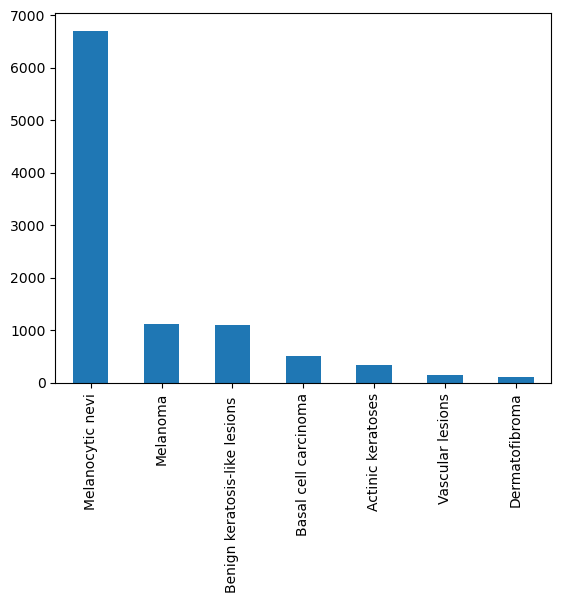

In [15]:
skin_df['cell_type'].value_counts().plot(kind='bar')
plt.show()

As we can see Melanocytic nevi is in higest number followed by Melanoma and benign keratosis-like lesions

# Bivariate Visualization

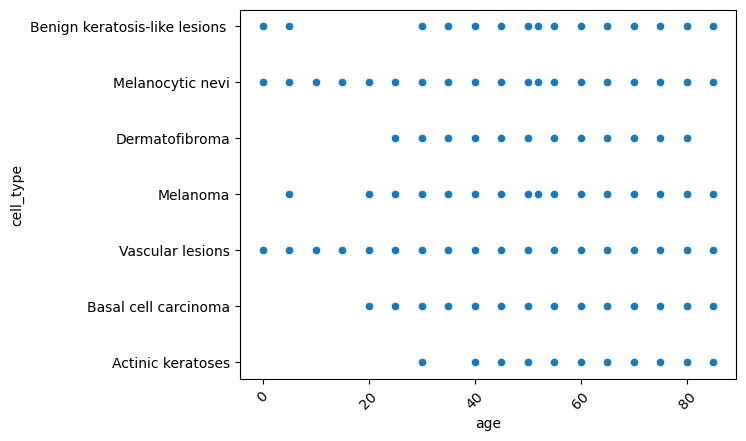

In [16]:
#Scatter plot between Age and cell_type
sns.scatterplot(x = 'age' ,  y ='cell_type' , data = skin_df)
plt.xticks(rotation = 45)
plt.show()

It seems that skin cancer like Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years

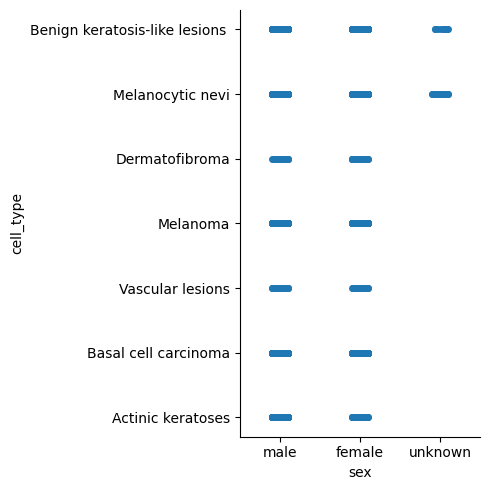

In [17]:
sns.catplot(x = 'sex' , y = 'cell_type', data=skin_df)
plt.show()

# Resizing Image

As there can be different image size in the dataset which will create problem for model so to solve it we are resizing all image to common dimension of 75 rows and 100 columns

In [18]:
#creating a column name 'image' containing array of dimensions
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))


# Splitting Training and Testing Dataset

In [19]:
features = skin_df.drop(columns = ['cell_type_idx'] , axis = 1)
target = skin_df['cell_type_idx']


In [20]:
x_traino , x_testo , y_traino , y_testo = train_test_split(features , target , test_size=0.2 , random_state=88)


# Normalizing Training and Testing Data

Normalization is an essential preprocessing step in machine learning and deep learning models. It involves scaling the input data to a standard range or distribution.
It is used for following task
1. Equalizing the scales
2. Improving model performance
3. Avoiding bias towards certain features
4. Stabilizing model training
5. Handling outliers
6. Enabling comparison across features

In this we have used Decimal Scaling which shifs the decimal point of the values to normalize the data

In [21]:
x_train = np.asarray(x_traino['image'].tolist())
x_test = np.asarray(x_testo['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding

Label encoding is a preprocessing technique used to convert categorical labels into numerical values. It is commonly applied when dealing with categorical variables in machine learning and data analysis tasks. The goal of label encoding is to represent categorical labels in a way that can be understood by machine learning algorithms.

Here to_categorical is used to convert integer labels into one-hot encoded vectors. One-hot encoding is a common technique used to represent categorical variables as binary vectors, where each category is represented by a binary value (0 or 1) in a vector.

In [22]:

y_train = to_categorical(y_traino, num_classes = 7)
y_test = to_categorical(y_testo, num_classes = 7)



# Splitting Training and Validation split

There are total of 3 types of dataset 
1. Training dataset 
2. Testing Dataset 
3. Validation Dataset


Testing Dataset  generally is use for finding accuracy and for performance matrics whereas Validation dataset is used for hyperparameter tuning or model selection , etc.

Therefore we have divided training dataset further into training and validation dataset

In [23]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# CNN Model Building

A Convolutional Neural Network (CNN) is a type of deep learning model commonly used for analyzing visual data, such as images or videos. It is particularly effective in tasks like image classification, object detection, and image segmentation

In this code we have use:

1. Input Layer:

    Input shape: (75, 100, 3)
    
    Represents the shape of the input images, where 75 is the height, 100     is the width, and 3 is the number of color channels (RGB).

2.  Convolutional Layers:

    Conv2D layer with 32 filters, kernel size of (3,3), and ReLU      activation.
    
    Conv2D layer with 32 filters, kernel size of (3,3), and ReLU activation.
    
    Both layers use 'Same' padding to preserve the spatial dimensions of the input.
    
    These layers perform feature extraction by applying convolution operations on the input images.
    
3.  MaxPooling Layer:

    MaxPool2D layer with a pool size of (2,2).
    
    Performs max pooling operation to downsample the feature maps by selecting the maximum value within each pooling region.
    
4. Dropout Layer:

    Dropout layer with a dropout rate of 0.25.
    
    Helps prevent overfitting by randomly setting a fraction of input units to 0 during training.
    
5. Additional Convolutional Layers and Dropout:

    Two more sets of Conv2D, Conv2D, MaxPool2D, and Dropout layers are added with increased filter size and dropout rate.
    
    The second set has 64 filters and a dropout rate of 0.40.
    
6. Flatten Layer:

    Flattens the output from the previous layers into a 1D vector to prepare for the fully connected layers.
    
7. Fully Connected Layers:

    Dense layer with 128 neurons and ReLU activation.
    
    Dropout layer with a dropout rate of 0.5.

8. Output Layer:

    Dense layer with num_classes (7 in this case) neurons and softmax activation.
    
    Produces the final output probabilities for each class.


In [24]:
input_shape = (75,100,3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32 , kernel_size = (3,3) , activation='relu' , padding ='Same' , input_shape = input_shape))
model.add(Conv2D(32 , kernel_size=(3,3) , activation='relu' , padding='Same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3,3) , activation='relu' , padding ='Same'))
model.add(Conv2D(64, kernel_size = (3,3) , activation='relu' , padding='Same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes , activation='softmax'))

# Optimizer


In deep learning, an optimizer is an algorithm or method used to adjust the weights and biases of a neural network during the training process. The goal of an optimizer is to minimize the loss function and optimize the network's performance by finding the optimal set of weights that result in accurate predictions.

Some optimizers are:

1. Gradient Descent
2. Batch Gradient Descent
3. Stochastic Gradient Descent
4. MiniBatch Gradient Descent
5. Adam
6. Adagrad
7. RMSprop , etc.

The Adam optimizer is an optimization algorithm commonly used in deep learning. It combines the advantages of two other optimization methods, namely AdaGrad and RMSprop, to provide efficient and effective weight updates during training.

lr =  Learning Rate

beta_1 = Exponential Decay rate for the first momentum

beta_2 = Exponential Decay rate for the second momentum

epsilon = It is a small constant added to the denominator to improve               numerical stability. In this case, epsilon is set to None,               which means  the default value will be used.

amsgrad = It is a boolean flag indicating whether to use the AMSGrad variant of Adam optimizer. When set to False, the regular Adam optimizer is used. 



In [25]:
 optimizer = Adam(lr=0.001 , beta_2 = 0.999 , beta_1 = 0.9 , epsilon = None , amsgrad=False)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


compile model using Adam optimizer , categorical_crossentropy as it is classification problem , and accuracy mertrics

<!-- Now compile the model using Adam optimizer , categorical_crossentropty as it is classification problem and accuracy metrics -->

In [26]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy" , metrics=['accuracy'])

# Callback function

Callback functions are objects that can be used to customize and extend the behavior of the training process. Callbacks are passed to the fit() function during model training and are executed at various points during training, allowing you to perform additional actions or modifications.

ReduceLROnPlateau is used to dynamically adjust the learning rate during training based on the validation accuracy.

monitor =  It specifies the metric to be monitored for the learning rate reduction. In this case, 'val_acc' is used, which typically represents the validation accuracy.

patience = It determines the number of epochs with no improvement in the monitored metric after which the learning rate will be reduced. In this case, patience=3 means that if the validation accuracy does not improve for 3 consecutive epochs, the learning rate will be adjusted.

verbose = It controls the verbosity of the callback. Setting verbose=1 means that a message will be printed to indicate when the learning rate is reduced.

factor = It specifies the factor by which the learning rate will be reduced. In this case, factor=0.5 means that the learning rate will be multiplied by 0.5 when it needs to be reduced.

min_lr = It specifies the factor by which the learning rate will be reduced. In this case, factor=0.5 means that the learning rate will be multiplied by 0.5 when it needs to be reduced.

In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc' , patience=3,verbose=1,factor=0.5,min_tr=0.0001)

# Data Augmentation

Data augmentation is a technique used in deep learning and computer vision to artificially increase the size and diversity of a training dataset by applying various transformations and modifications to the existing data. 

In [28]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# .fit() metyhod is use to calculate the necessary statistic required for the data augmentation and preprocessing
datagen.fit(x_train)


# Traning of Model using Data Generated

.fit_generator() method is use to train a model using Data generated by the ImageDataGenerator



datagen.flow(x_train, y_train, batch_size=batch_size): This generates augmented batches of data using the ImageDataGenerator object (datagen). It takes the training data (x_train and y_train) as inputs and generates batches of size batch_size.

epochs: This parameter specifies the number of times the entire training dataset will be iterated over during the training process.

verbose: This parameter determines the verbosity mode. A value of 1 displays a progress bar for each epoch, while 0 or 2 displays no progress bar.

steps_per_epoch: This parameter specifies the number of steps (batches) to be taken in each epoch. It is typically calculated as the total number of training samples divided by the batch size.

callbacks: This parameter is used to specify a list of callbacks to be applied during training. In this case, the learning_rate_reduction callback is included. 

In [29]:
epochs = 50
batch_size = 10
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs,validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


2023-06-22 18:19:33.901030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


721/721 [==============================] - 24s 24ms/step - loss: 1.0212 - accuracy: 0.6601 - val_loss: 0.8955 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 2/50
721/721 [==============================] - 17s 23ms/step - loss: 0.9187 - accuracy: 0.6687 - val_loss: 0.8521 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 3/50
721/721 [==============================] - 16s 22ms/step - loss: 0.9006 - accuracy: 0.6745 - val_loss: 0.8755 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 4/50
721/721 [==============================] - 17s 23ms/step - loss: 0.8862 - accuracy: 0.6736 - val_loss: 0.8554 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 5/50
721/721 [==============================] - 17s 23ms/step - loss: 0.8579 - accuracy: 0.6821 - val_loss: 1.0630 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 6/50
721/721 [==============================] - 16s 22ms/step - loss: 0.8740 - accuracy: 0.6796 - val_loss: 0.8668 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 7/50
721/721 [==============================] - 16s 23ms/step -

# Model Evaluation

Model evaluation is the process of assessing the performance and quality of a trained machine learning model. It involves measuring how well the model performs on unseen data and determining its ability to generalize to new examples. Model evaluation helps in understanding the model's strengths, weaknesses, and its suitability for the intended task.

In [30]:
# This line evalutes the loss and accuracy for x_test and y_test with verbose = 1 which is use to display progress during evaluation 
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
# This line evalutes the loss and accuracy for x_val and y_val with verbose = 1 which is use to display progress during evaluation 
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
#print accuaracy and loss
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

model.save("model.h5")

26/26 [==============================] - 0s 5ms/step - loss: 0.7637 - accuracy: 0.7594
Validation: accuracy = 0.759352  ;  loss_v = 0.763731
Test: accuracy = 0.721418  ;  loss = 0.789902


In [33]:
#y_pred for predicted value
y_pred = model.predict(x_validate)
#storing max value index in y_pred_class
y_pred_class = np.argmax(y_pred , axis = 1 )
#y_true with orginal true value
y_true = np.argmax(y_validate,axis = 1) 


26/26 [==============================] - 0s 4ms/step


# Confusion Metrics

The confusion matrix is a table that is often used to describe the performance of a classification model. It shows the number of true positive, true negative, false positive, and false negative predictions made by the model.

In [34]:
# Create a confusion matrix
confusion_m = confusion_matrix(y_true , y_pred_class)

<Axes: >

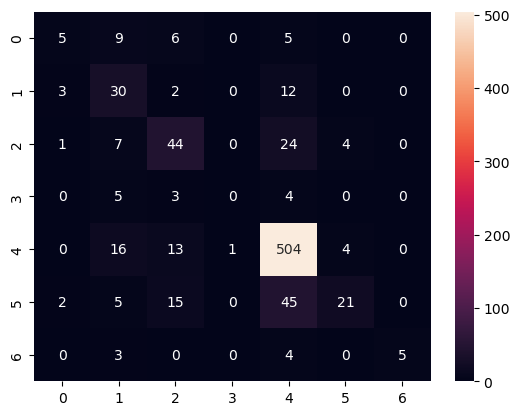

In [35]:
#plot the conofusion matrix  using heatmap
# fmt='g': This parameter specifies the format of the annotations. In this case, 'g' stands for the general format, which automatically chooses between a decimal representation or scientific notation depending on the value.
# annot=True: This parameter specifies that the cell values of the heatmap should be annotated with the actual count values from the confusion matrix
sns.heatmap(confusion_m , annot=True , fmt='g')

From this heatmap it seems that cell_type_idx which is 3 also as Basal cell carcinoma is most misclassified follwed by  

In [36]:
accuracy = accuracy_score(y_true , y_pred_class)
print("Accuracy:" , round(accuracy*100 , 2) ,"%")

Accuracy: 75.94 %
